In [34]:
%matplotlib inline
from matplotlib import pyplot as plt

In [35]:
from __future__ import division

In [36]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

In [37]:
import seaborn as sns

In [38]:
pslp = "/home/gus/MEGAsync/zim/main/Yale/Collaborations/Hongyu-tsetse/Xiaoqing/transcripts/2016-02-05_comprehensive_Gmm_transcript_set/gmm_transcripts_v_GfusI1_scaffold.dna2dna.psl"

tx_orthos_out = "/home/gus/MEGAsync/zim/main/Yale/Collaborations/Hongyu-tsetse/Find_Gff_sequences_from_Gmm_RNA-seq_transcriptome/existing_genes/xiaoqing_orthologous_Tx_GMOY_GFUI_comp_Tx_assemb.xls"

In [39]:
!head $pslp

psLayout version 3

match	mis- 	rep. 	N's	Q gap	Q gap	T gap	T gap	strand	Q        	Q   	Q    	Q  	T        	T   	T    	T  	block	blockSizes 	qStarts	 tStarts
     	match	match	   	count	bases	count	bases	      	name     	size	start	end	name     	size	start	end	count
---------------------------------------------------------------------------------------------------------------------------------------------------------------
59	4	0	0	0	0	0	0	-	TCONS_00000002	701	10	73	Scaffold835	83713	61403	61466	1	63,	628,	61403,
214	17	0	0	2	44	4	1014	-	TCONS_00000002	701	426	701	Scaffold279	409266	391031	392276	5	40,32,52,41,66,	0,40,72,135,209,	391031,391073,391108,391161,392210,
31	1	0	0	0	0	0	0	+	TCONS_00000011	2067	1743	1775	JFJR01011277	36943	33011	33043	1	32,	1743,	33011,
53	3	0	0	1	2	1	10	+	TCONS_00000025	2622	724	782	Scaffold99	785325	650817	650883	2	23,33,	724,749,	650817,650850,
66	2	0	0	1	10	3	434	+	TCONS_00000025	2622	709	787	Scaffold959	57771	26	528	4	13,24,16,15,	709,722,756,772,	26,367

In [40]:
def psl_to_dataframe(psl_path):
    """Read PSL into dataframe."""
    head = pd.read_csv(filepath_or_buffer=psl_path, sep='\t', 
                    header=None,
                    skiprows=2, 
                    nrows=3,)
    
    head = head.applymap(lambda i: i if pd.notnull(i) else '')
    
    h1 = head.iloc[0,:]
    h2 = head.iloc[1,:]
    
    col_names = (h1 + h2).apply(lambda i: i.replace(' ','').replace('-','').replace("'",'').replace(".",'')).str.lower()
    
    
    df = pd.read_csv(filepath_or_buffer=psl_path, sep='\t', 
                    header=None, 
                    names=col_names,
                    skiprows=5,  
                    nrows=None,)
    
    return df
    
    

def add_coverage_to_psl(psl):
    """Modify psl to have new column named 'coverage' containing coverage fraction.
    
    Return: None
    """
    psl['coverage'] = psl.match / psl.qsize

def filter_psl(psl, coverage=0.90, qsize=60):
    """Return new psl dataframe after filtering."""
    psl_ = psl.query(''' coverage >= {coverage} '''.format(coverage=coverage)).query(''' qsize >= {qsize} '''.format(qsize=qsize))
    
    return psl_

def psl_to_bed(psl):
    """Return new bed dataframe converted from psl dataframe.
    
    | BED         | PSL           |
    | --          | --            |
    | chrom       | tname         |
    | chromStart  | tstart        |
    | chromEnd    | tend          |
    | name        | qname         |
    | score       | 0             |
    | strand      | strand        |
    | thickStart  | tname         |
    | thickEnd    | tstart        |
    | itemRgb     | "255,255,255" |
    | blockCount  | blockcount    |
    | blockSizes  | blocksizes    |
    | blockStarts | tstarts       |
    """
    bed = pd.DataFrame()
    
    bed["chrom"] = psl["tname"].copy()
    bed["chromStart"] = psl["tstart"].copy()
    bed["chromEnd"] = psl["tend"].copy()
    bed["name"] = psl["qname"].copy()
    bed["score"] = 0
    bed["strand"] = psl["strand"].copy()
    bed["thickStart"] = psl["tstart"].copy()
    bed["thickEnd"] = psl["tend"].copy()
    bed["itemRgb"] = "255,255,255"
    bed["blockCount"] = psl["blockcount"].copy()
    bed["blockSizes"] = psl["blocksizes"].copy()
    bed["blockStarts"] = psl["tstarts"].copy()
    
    return bed

In [41]:
df = psl_to_dataframe("/home/gus/PSL.tsv")
df

,match,mismatch,repmatch,ns,qgapcount,qgapbases,tgapcount,tgapbases,strand,qname,qsize,qstart,qend,tname,tsize,tstart,tend,blockcount,blocksizes,qstarts,tstarts
0,59,4,0,0,0,0,0,0,-,TCONS_00000002,701,10,73,Scaffold835,83713,61403,61466,1,"63,","628,","61403,"
1,214,17,0,0,2,44,4,1014,-,TCONS_00000002,701,426,701,Scaffold279,409266,391031,392276,5,"40,32,52,41,66,","0,40,72,135,209,","391031,391073,391108,391161,392210,"
2,31,1,0,0,0,0,0,0,+,TCONS_00000011,2067,1743,1775,JFJR01011277,36943,33011,33043,1,"32,","1743,","33011,"
3,53,3,0,0,1,2,1,10,+,TCONS_00000025,2622,724,782,Scaffold99,785325,650817,650883,2,"23,33,","724,749,","650817,650850,"
4,66,2,0,0,1,10,3,434,+,TCONS_00000025,2622,709,787,Scaffold959,57771,26,528,4,"13,24,16,15,","709,722,756,772,","26,367,393,513,"


In [42]:
test_bed = psl_to_bed(df)
test_bed

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,Scaffold835,61403,61466,TCONS_00000002,0,-,61403,61466,"255,255,255",1,"63,","61403,"
1,Scaffold279,391031,392276,TCONS_00000002,0,-,391031,392276,"255,255,255",5,"40,32,52,41,66,","391031,391073,391108,391161,392210,"
2,JFJR01011277,33011,33043,TCONS_00000011,0,+,33011,33043,"255,255,255",1,"32,","33011,"
3,Scaffold99,650817,650883,TCONS_00000025,0,+,650817,650883,"255,255,255",2,"23,33,","650817,650850,"
4,Scaffold959,26,528,TCONS_00000025,0,+,26,528,"255,255,255",4,"13,24,16,15,","26,367,393,513,"


In [43]:
df['coverage'] = df.match / df.qsize
df

,match,mismatch,repmatch,ns,qgapcount,qgapbases,tgapcount,tgapbases,strand,qname,qsize,qstart,qend,tname,tsize,tstart,tend,blockcount,blocksizes,qstarts,tstarts,coverage
0,59,4,0,0,0,0,0,0,-,TCONS_00000002,701,10,73,Scaffold835,83713,61403,61466,1,"63,","628,","61403,",0.084165
1,214,17,0,0,2,44,4,1014,-,TCONS_00000002,701,426,701,Scaffold279,409266,391031,392276,5,"40,32,52,41,66,","0,40,72,135,209,","391031,391073,391108,391161,392210,",0.305278
2,31,1,0,0,0,0,0,0,+,TCONS_00000011,2067,1743,1775,JFJR01011277,36943,33011,33043,1,"32,","1743,","33011,",0.014998
3,53,3,0,0,1,2,1,10,+,TCONS_00000025,2622,724,782,Scaffold99,785325,650817,650883,2,"23,33,","724,749,","650817,650850,",0.020214
4,66,2,0,0,1,10,3,434,+,TCONS_00000025,2622,709,787,Scaffold959,57771,26,528,4,"13,24,16,15,","709,722,756,772,","26,367,393,513,",0.025172


In [44]:
61466-61403

63

In [45]:
psl = psl_to_dataframe(pslp)
psl.head()

,match,mismatch,repmatch,ns,qgapcount,qgapbases,tgapcount,tgapbases,strand,qname,qsize,qstart,qend,tname,tsize,tstart,tend,blockcount,blocksizes,qstarts,tstarts
0,59,4,0,0,0,0,0,0,-,TCONS_00000002,701,10,73,Scaffold835,83713,61403,61466,1,"63,","628,","61403,"
1,214,17,0,0,2,44,4,1014,-,TCONS_00000002,701,426,701,Scaffold279,409266,391031,392276,5,"40,32,52,41,66,","0,40,72,135,209,","391031,391073,391108,391161,392210,"
2,31,1,0,0,0,0,0,0,+,TCONS_00000011,2067,1743,1775,JFJR01011277,36943,33011,33043,1,"32,","1743,","33011,"
3,53,3,0,0,1,2,1,10,+,TCONS_00000025,2622,724,782,Scaffold99,785325,650817,650883,2,"23,33,","724,749,","650817,650850,"
4,66,2,0,0,1,10,3,434,+,TCONS_00000025,2622,709,787,Scaffold959,57771,26,528,4,"13,24,16,15,","709,722,756,772,","26,367,393,513,"


In [46]:
# psl = psl_to_dataframe(pslp)
add_coverage_to_psl(psl)

filtered_psl = filter_psl(psl, coverage=0.90, qsize=60)

bed = psl_to_bed(filtered_psl)


In [47]:
len(filtered_psl.qname.unique())

20864

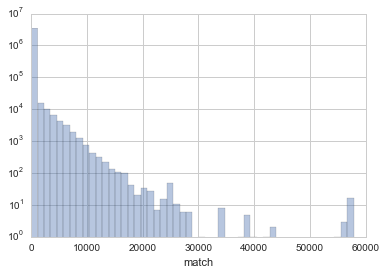

In [48]:
sns.distplot(psl.match, kde=False, rug=False)
plt.yscale('log');

In [49]:
# psl['coverage'] = (psl.match - psl.mismatch) / psl.qsize

In [50]:
psl['coverage'] = psl.match / psl.qsize

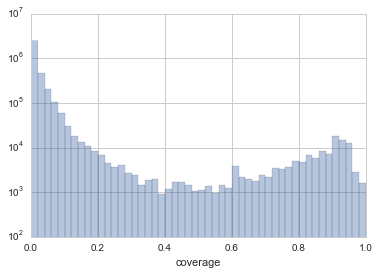

In [51]:
sns.distplot(psl.coverage, kde=False, rug=False);
plt.yscale('log');

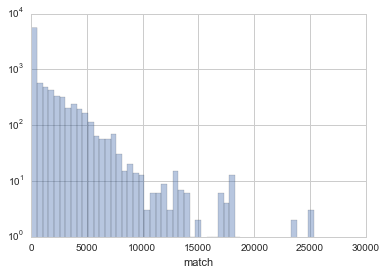

In [52]:
sns.distplot(psl.query(''' coverage >= 0.95 ''').match, kde=False, rug=False)
plt.yscale('log');

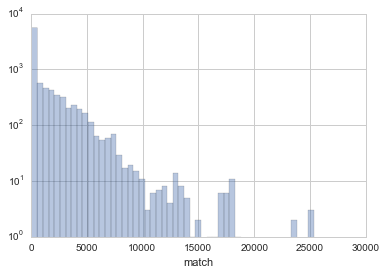

In [53]:
sns.distplot(psl.query(''' coverage >= 0.95 ''').query(''' qsize >= 60 ''').match, kde=False, rug=False)
plt.yscale('log');

In [54]:
hits_per_tx = psl.groupby('qname').match.agg(len)

In [55]:
hits_per_tx_cov80 = psl.query(''' coverage >= 0.8 ''').groupby('qname').match.agg(len)

In [56]:
hits_per_tx_cov95 = psl.query(''' coverage >= 0.95 ''').query(''' qsize >= 60 ''').groupby('qname').match.agg(len)

In [57]:
hits_per_tx_cov90 = psl.query(''' coverage >= 0.90 ''').query(''' qsize >= 60 ''').groupby('qname').match.agg(len)

In [58]:
hits_per_tx_cov80.max()

1245

In [59]:
hits_per_tx_cov95.max()

226

In [60]:
hits_per_tx_cov90.max()

982

In [61]:
hits_per_tx_cov90.mean()

2.3978144171779143

In [62]:
hits_per_tx_cov90.median()

1.0

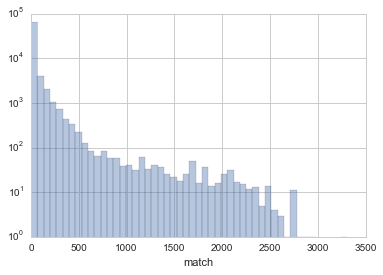

In [63]:
sns.distplot(hits_per_tx, kde=False)
plt.yscale('log');

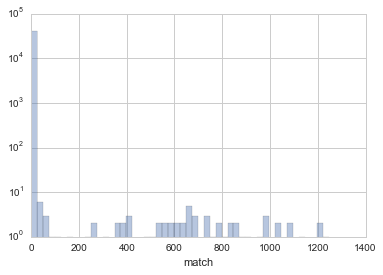

In [64]:
sns.distplot(hits_per_tx_cov80, kde=False)
plt.yscale('log');

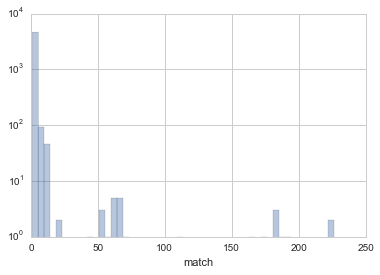

In [65]:
sns.distplot(hits_per_tx_cov95, kde=False)
plt.yscale('log');

In [66]:
len(hits_per_tx_cov95)

4826

In [67]:
len(hits_per_tx_cov90)

20864

In [68]:
len(psl.qname.unique())

74606

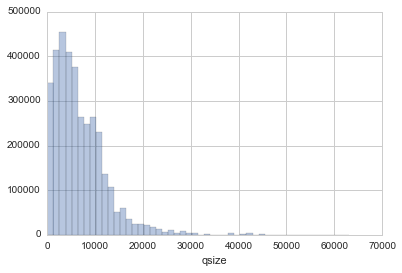

In [69]:
sns.distplot(psl.qsize, kde=False)
# plt.yscale('log');
# plt.xlim(0,500)

In [70]:
orthos = pd.read_excel(tx_orthos_out)
orthos.head()

,tx_tcons,Gene stable ID,Glossina fuscipes fuscipes gene stable ID,Homology type,% identity,Glossina fuscipes fuscipes % identity,dN,dS,"Orthology confidence [0 low, 1 high]"
0,TCONS_00079161,GMOY010987,GFUI030682,ortholog_one2one,79,87,0.0308,0.1263,1
1,TCONS_00079151,GMOY010987,GFUI030682,ortholog_one2one,79,87,0.0308,0.1263,1
2,TCONS_00079163,GMOY010987,GFUI030682,ortholog_one2one,79,87,0.0308,0.1263,1
3,TCONS_00079141,GMOY010987,GFUI030682,ortholog_one2one,79,87,0.0308,0.1263,1
4,TCONS_00079146,GMOY010987,GFUI030682,ortholog_one2one,79,87,0.0308,0.1263,1


In [71]:
psl.query(''' qname == "TCONS_00079161" ''')

,match,mismatch,repmatch,ns,qgapcount,qgapbases,tgapcount,tgapbases,strand,qname,qsize,qstart,qend,tname,tsize,tstart,tend,blockcount,blocksizes,qstarts,tstarts,coverage
3249161,2204,80,0,0,8,64,17,39601,+,TCONS_00079161,2414,0,2348,Scaffold3,2629603,1421685,1463570,22,"26,61,139,115,110,180,213,120,142,333,51,14,96...","0,68,129,268,383,500,680,893,1013,1161,1494,15...","1421685,1458083,1458212,1458417,1458616,145873...",0.913007


# Gmm Tx length vs number of mappings

In [72]:
psl.head()

,match,mismatch,repmatch,ns,qgapcount,qgapbases,tgapcount,tgapbases,strand,qname,qsize,qstart,qend,tname,tsize,tstart,tend,blockcount,blocksizes,qstarts,tstarts,coverage
0,59,4,0,0,0,0,0,0,-,TCONS_00000002,701,10,73,Scaffold835,83713,61403,61466,1,"63,","628,","61403,",0.084165
1,214,17,0,0,2,44,4,1014,-,TCONS_00000002,701,426,701,Scaffold279,409266,391031,392276,5,"40,32,52,41,66,","0,40,72,135,209,","391031,391073,391108,391161,392210,",0.305278
2,31,1,0,0,0,0,0,0,+,TCONS_00000011,2067,1743,1775,JFJR01011277,36943,33011,33043,1,"32,","1743,","33011,",0.014998
3,53,3,0,0,1,2,1,10,+,TCONS_00000025,2622,724,782,Scaffold99,785325,650817,650883,2,"23,33,","724,749,","650817,650850,",0.020214
4,66,2,0,0,1,10,3,434,+,TCONS_00000025,2622,709,787,Scaffold959,57771,26,528,4,"13,24,16,15,","709,722,756,772,","26,367,393,513,",0.025172


In [73]:
psl_qname_qsize = psl[["qname","qsize"]].drop_duplicates().set_index('qname')
psl_qname_qsize.head()

,qsize
qname,
TCONS_00000002,701
TCONS_00000011,2067
TCONS_00000025,2622
TCONS_00000027,1896
TCONS_00000029,72


In [74]:
hits_per_tx.head()

qname
TCONS_00000002     2
TCONS_00000011     1
TCONS_00000025    50
TCONS_00000027     2
TCONS_00000029     4
Name: match, dtype: int64

In [75]:
psl_qname_qsize.shape

(74606, 1)

In [76]:
pd.DataFrame(hits_per_tx).shape

(74606, 1)

In [77]:
psl_qname_qsize_hits = pd.merge(left=psl_qname_qsize, right=pd.DataFrame(hits_per_tx), 
                                how='inner', 
                                on=None, left_on=None, right_on=None, 
                                left_index=True, right_index=True, 
                                sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)
psl_qname_qsize_hits.head()

,qsize,match
qname,,
TCONS_00000002,701,2
TCONS_00000011,2067,1
TCONS_00000025,2622,50
TCONS_00000027,1896,2
TCONS_00000029,72,4


In [78]:
psl_qname_qsize_hits_filter = pd.merge(left=psl_qname_qsize, right=pd.DataFrame(hits_per_tx_cov90), 
                                how='inner', 
                                on=None, left_on=None, right_on=None, 
                                left_index=True, right_index=True, 
                                sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)
psl_qname_qsize_hits_filter.head()

,qsize,match
qname,,
TCONS_00000037,7704,1
TCONS_00000050,7313,1
TCONS_00000051,7215,1
TCONS_00000056,7522,1
TCONS_00000070,2059,1


In [79]:
psl_qname_qsize_hits['qsize_log10'] = np.log10(psl_qname_qsize_hits.qsize)
psl_qname_qsize_hits['match_log10'] = np.log10(psl_qname_qsize_hits.match)

In [80]:
psl_qname_qsize_hits_filter['qsize_log10'] = np.log10(psl_qname_qsize_hits_filter.qsize)
psl_qname_qsize_hits_filter['match_log10'] = np.log10(psl_qname_qsize_hits_filter.match)

/home/gus/anaconda2/envs/stack2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


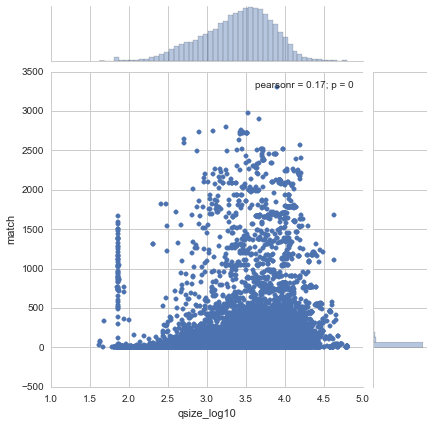

In [81]:
sns.jointplot('qsize_log10', 'match', data=psl_qname_qsize_hits.sample(frac=1), kind='scatter');

In [82]:
10**1.8

63.09573444801933

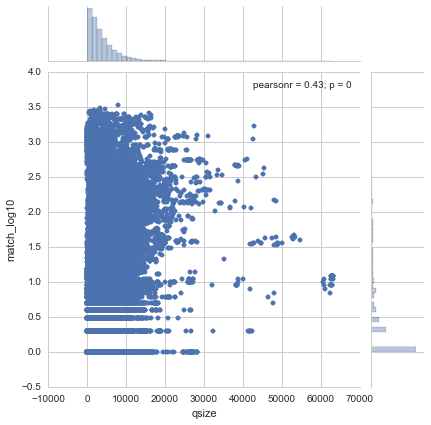

In [83]:
sns.jointplot('qsize', 'match_log10', data=psl_qname_qsize_hits.sample(frac=1), kind='scatter');

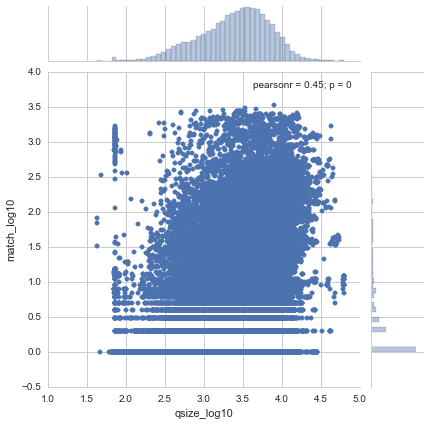

In [84]:
sns.jointplot('qsize_log10', 'match_log10', data=psl_qname_qsize_hits.sample(frac=1), kind='scatter');

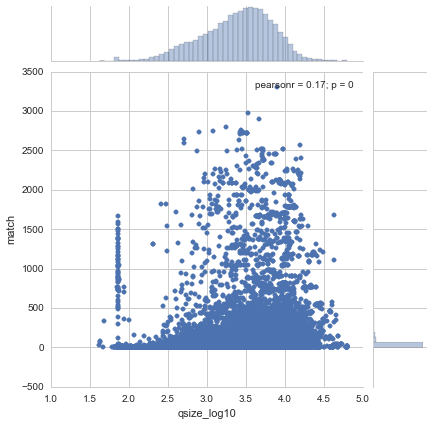

In [85]:
sns.jointplot('qsize_log10', 'match', data=psl_qname_qsize_hits.sample(frac=1), );

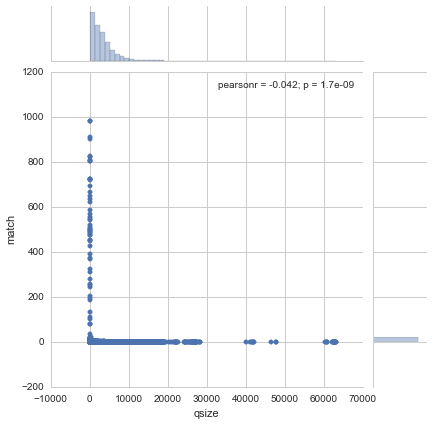

In [89]:
sns.set_style("whitegrid")
sns.jointplot('qsize', 'match', data=psl_qname_qsize_hits_filter.sample(frac=1), );
# plt.xlim(60,80)

In [ ]:
plt.savefig()

In [149]:
hit_spike = psl.query('''qsize == 73 ''').query(''' coverage >= 0.9 ''')
hit_spike

,match,mismatch,repmatch,ns,qgapcount,qgapbases,tgapcount,tgapbases,strand,qname,qsize,qstart,qend,tname,tsize,tstart,tend,blockcount,blocksizes,qstarts,tstarts,coverage
64057,66,6,0,0,0,0,0,0,+,TCONS_00001574,73,1,73,Scaffold980,47485,28550,28622,1,"72,","1,","28550,",0.904110
64112,66,6,0,0,0,0,0,0,+,TCONS_00001574,73,1,73,Scaffold682,152231,127114,127186,1,"72,","1,","127114,",0.904110
64114,67,5,0,0,0,0,0,0,+,TCONS_00001574,73,1,73,Scaffold673,128082,21020,21092,1,"72,","1,","21020,",0.917808
64115,66,6,0,0,0,0,0,0,+,TCONS_00001574,73,1,73,Scaffold662,145005,94432,94504,1,"72,","1,","94432,",0.904110
64116,66,6,0,0,0,0,0,0,+,TCONS_00001574,73,1,73,Scaffold662,145005,4313,4385,1,"72,","1,","4313,",0.904110
64121,66,6,0,0,0,0,0,0,+,TCONS_00001574,73,1,73,Scaffold637,146957,60953,61025,1,"72,","1,","60953,",0.904110
64131,66,6,0,0,0,0,0,0,+,TCONS_00001574,73,1,73,Scaffold6,2427971,798543,798615,1,"72,","1,","798543,",0.904110
64152,66,6,0,0,0,0,0,0,+,TCONS_00001574,73,1,73,Scaffold55,1161968,771183,771255,1,"72,","1,","771183,",0.904110
64161,66,6,0,0,0,0,1,1,+,TCONS_00001574,73,1,73,Scaffold522,215051,160777,160850,2,"8,64,","1,9,","160777,160786,",0.904110
64162,66,6,0,0,0,0,0,0,+,TCONS_00001574,73,1,73,Scaffold514,209919,137861,137933,1,"72,","1,","137861,",0.904110


In [160]:
len(hit_spike.qname.unique())

127

In [150]:
hit_spike.qname.max()

'TCONS_00085756'

In [153]:
orthos.head()

,tx_tcons,Gene stable ID,Glossina fuscipes fuscipes gene stable ID,Homology type,% identity,Glossina fuscipes fuscipes % identity,dN,dS,"Orthology confidence [0 low, 1 high]"
0,TCONS_00079161,GMOY010987,GFUI030682,ortholog_one2one,79,87,0.0308,0.1263,1
1,TCONS_00079151,GMOY010987,GFUI030682,ortholog_one2one,79,87,0.0308,0.1263,1
2,TCONS_00079163,GMOY010987,GFUI030682,ortholog_one2one,79,87,0.0308,0.1263,1
3,TCONS_00079141,GMOY010987,GFUI030682,ortholog_one2one,79,87,0.0308,0.1263,1
4,TCONS_00079146,GMOY010987,GFUI030682,ortholog_one2one,79,87,0.0308,0.1263,1


In [155]:
hit_spike_gene = pd.merge(left=hit_spike, right=orthos[["tx_tcons","Gene stable ID","Glossina fuscipes fuscipes gene stable ID","Homology type"]], 
                          how='inner', 
                          on=None, left_on="qname", right_on="tx_tcons", 
                          left_index=False, right_index=False, 
                          sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)
hit_spike_gene

,match,mismatch,repmatch,ns,qgapcount,qgapbases,tgapcount,tgapbases,strand,qname,qsize,qstart,qend,tname,tsize,tstart,tend,blockcount,blocksizes,qstarts,tstarts,coverage,tx_tcons,Gene stable ID,Glossina fuscipes fuscipes gene stable ID,Homology type
0,70,3,0,0,0,0,0,0,-,TCONS_00026583,73,0,73,Scaffold24,1582614,544995,545068,1,"73,","0,","544995,",0.958904,TCONS_00026583,GMOY003736,GFUI019393,ortholog_one2one


# How many of filtered Tcons are annotated in Gmm?

In [165]:
hits_per_tx_cov90_genes = pd.merge(left=pd.DataFrame(hits_per_tx_cov90), right=orthos[["tx_tcons","Gene stable ID","Glossina fuscipes fuscipes gene stable ID","Homology type"]], 
                          how='inner', 
                          on=None, left_on=None, right_on="tx_tcons", 
                          left_index=True, right_index=False, 
                          sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)
hits_per_tx_cov90_genes.head()

,match,tx_tcons,Gene stable ID,Glossina fuscipes fuscipes gene stable ID,Homology type
51012,1,TCONS_00000037,GMOY000012,GFUI045264,ortholog_one2one
32804,1,TCONS_00000050,GMOY000013,GFUI045265,ortholog_one2one
32801,1,TCONS_00000051,GMOY000013,GFUI045265,ortholog_one2one
32802,1,TCONS_00000056,GMOY000013,GFUI045265,ortholog_one2one
32599,1,TCONS_00000070,GMOY000016,GFUI045266,ortholog_one2one


In [167]:
len(hits_per_tx_cov90)

20864

In [94]:
len(set(hits_per_tx_cov90.index.values))

20864

In [93]:
len(hits_per_tx_cov90.index.values)

20864

In [169]:
len(hits_per_tx_cov90_genes.tx_tcons.unique())

15971

In [95]:
bed.to_csv(path_or_buf=None, sep='\t', header=False, index=False)

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
363,Scaffold706,49945,58941,TCONS_00000037,0,+,49945,58941,"255,255,255",25,"46,25,19,27,26,308,162,147,508,39,75,156,186,3...","49945,50031,50056,50082,50113,50151,50462,5069..."
364,Scaffold706,51468,58872,TCONS_00000050,0,-,51468,58872,"255,255,255",15,"125,7,70,237,72,312,501,1258,2030,96,650,456,3...","51468,51603,51617,51715,51953,52025,52337,5290..."
365,Scaffold706,51468,58871,TCONS_00000051,0,-,51468,58871,"255,255,255",15,"125,7,70,237,72,312,501,1258,2030,96,650,456,3...","51468,51603,51617,51715,51953,52025,52337,5290..."
410,Scaffold706,51998,66907,TCONS_00000056,0,-,51998,66907,"255,255,255",18,"27,312,1822,2030,151,658,456,378,483,368,4,212...","51998,52025,52337,54160,56190,56342,57032,5752..."
507,Scaffold706,112026,115218,TCONS_00000070,0,-,112026,115218,"255,255,255",11,"60,37,97,358,236,153,292,299,178,40,215,","112026,112093,112131,112391,112810,113105,1133..."


In [170]:
len(hits_per_tx_cov90) - len(hits_per_tx_cov90_genes.tx_tcons.unique())

4893